In [15]:
!pip install torch torchvision torchaudio
!pip install scikit-learn

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt


In [16]:
from google.colab import drive
drive.mount('/content/drive')

file_path = '/content/drive/MyDrive/Deep Learning/Week 1/Infrared.csv'
data = pd.read_csv(file_path)
data = data.dropna()
data.head()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Gender,Age,Ethnicity,T_atm,Humidity,Distance,T_offset1,Max1R13_1,Max1L13_1,aveAllR13_1,...,T_FHRC1,T_FHLC1,T_FHBC1,T_FHTC1,T_FH_Max1,T_FHC_Max1,T_Max1,T_OR1,T_OR_Max1,aveOralM
0,Male,41-50,White,24.0,28.0,0.8,0.7025,35.0300,35.3775,34.4000,...,33.4775,33.3725,33.4925,33.0025,34.5300,34.0075,35.6925,35.6350,35.6525,36.59
1,Female,31-40,Black or African-American,24.0,26.0,0.8,0.7800,34.5500,34.5200,33.9300,...,34.0550,33.6775,33.9700,34.0025,34.6825,34.6600,35.1750,35.0925,35.1075,37.19
2,Female,21-30,White,24.0,26.0,0.8,0.8625,35.6525,35.5175,34.2775,...,34.8275,34.6475,34.8200,34.6700,35.3450,35.2225,35.9125,35.8600,35.8850,37.34
3,Female,21-30,Black or African-American,24.0,27.0,0.8,0.9300,35.2225,35.6125,34.3850,...,34.4225,34.6550,34.3025,34.9175,35.6025,35.3150,35.7200,34.9650,34.9825,37.09
4,Male,18-20,White,24.0,27.0,0.8,0.8950,35.5450,35.6650,34.9100,...,35.1600,34.3975,34.6700,33.8275,35.4175,35.3725,35.8950,35.5875,35.6175,37.04


In [17]:
label_cols = ['Gender', 'Age', 'Ethnicity']
for col in label_cols:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])

X = data.drop(columns=['aveOralM'])
y = data['aveOralM']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42)


In [18]:
X_train_torch = torch.tensor(X_train, dtype=torch.float32)
X_test_torch = torch.tensor(X_test, dtype=torch.float32)
y_train_torch = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
y_test_torch = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

class RegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(RegressionModel, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
    def forward(self, x):
        return self.fc(x)

model_torch = RegressionModel(X_train.shape[1])
criterion = nn.MSELoss()
optimizer = optim.Adam(model_torch.parameters(), lr=0.001)

for epoch in range(100):
    model_torch.train()
    outputs = model_torch(X_train_torch)
    loss = criterion(outputs, y_train_torch)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


📊 PyTorch Evaluation:
RMSE: 21.8721
MSE : 478.3876
R²  : -2403.9056


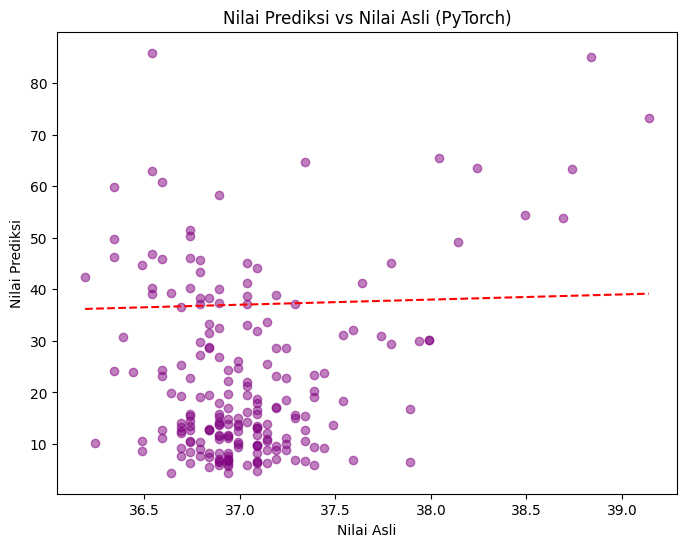

In [19]:
model_torch.eval()
y_pred_test = model_torch(X_test_torch).detach().numpy()
mse_torch = mean_squared_error(y_test, y_pred_test)
rmse_torch = np.sqrt(mse_torch)
r2_torch = r2_score(y_test, y_pred_test)

print("📊 PyTorch Evaluation:")
print(f"RMSE: {rmse_torch:.4f}")
print(f"MSE : {mse_torch:.4f}")
print(f"R²  : {r2_torch:.4f}")

# Visualisasi
plt.figure(figsize=(8, 6))
plt.scatter(y_test_torch.numpy(), y_pred_test, color='purple', alpha=0.5)
plt.plot([y_test_torch.min(), y_test_torch.max()], [y_test_torch.min(), y_test_torch.max()], color='red', linestyle='--')
plt.xlabel('Nilai Asli')
plt.ylabel('Nilai Prediksi')
plt.title('Nilai Prediksi vs Nilai Asli (PyTorch)')
plt.show()


In [20]:
model_tf = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])

model_tf.compile(optimizer='adam', loss='mse')
model_tf.fit(X_train, y_train, epochs=100, verbose=0)

y_pred_test_tf = model_tf.predict(X_test).flatten()
mse_tf = mean_squared_error(y_test, y_pred_test_tf)
rmse_tf = np.sqrt(mse_tf)
r2_tf = r2_score(y_test, y_pred_test_tf)

print("\n📊 TensorFlow Evaluation:")
print(f"RMSE: {rmse_tf:.4f}")
print(f"MSE : {mse_tf:.4f}")
print(f"R²  : {r2_tf:.4f}")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

📊 TensorFlow Evaluation:
RMSE: 1.3082
MSE : 1.7115
R²  : -7.6037


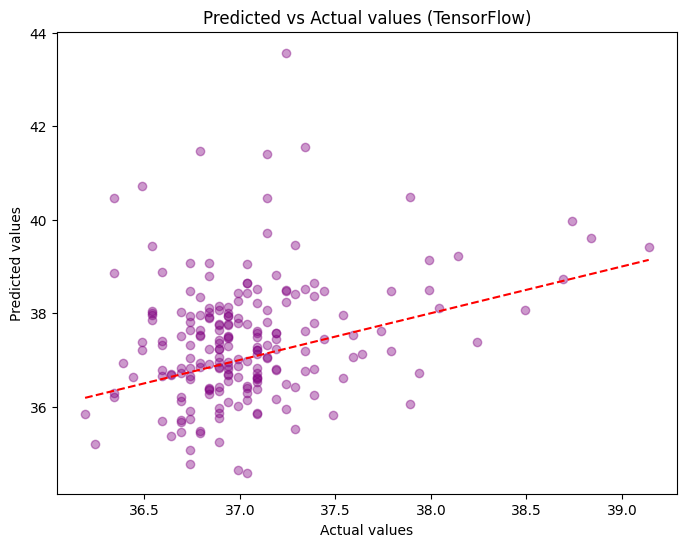

In [21]:
y_test_np = y_test.to_numpy()
y_pred_test_np = y_pred_test_tf

plt.figure(figsize=(8, 6))
plt.scatter(y_test_np, y_pred_test_np, color='purple', alpha=0.4)
plt.plot([y_test_np.min(), y_test_np.max()], [y_test_np.min(), y_test_np.max()], color='red', linestyle='--')
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.title('Predicted vs Actual values (TensorFlow)')
plt.show()
